# 교통량

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re


import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline, Pipeline

from google.colab import drive
drive.mount('/content/drive')
!pip install feature_engine
from feature_engine.encoding import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
#준혁님이 준 영등포구 도로 교통량 두 번째 시트 (selected Datasets)
selected_roads = pd.read_excel("/content/drive/MyDrive/환경 공모전/영등포구 도로 교통량.xlsx",sheet_name='Sheet1')

In [ ]:
selected_roads.head()

,도로명,시점명,종점명,상하행,거리,차선수,기능유형,도심/외곽,자치구명,연간평균,1월,2월,3월,4월,5월
0,가마산로,신길가마산로,성락주유소앞,상행,750,3,보조간선도로,외곽,영등포구,18.30,18.02,18.18,18.38,18.60,6.100000
1,가마산로,성락주유소앞,성락빌딩앞,상행,272,3,보조간선도로,외곽,영등포구,22.20,22.03,22.03,22.42,22.33,7.400000
2,가마산로,성락빌딩앞,대림3동사거리,상행,416,3,보조간선도로,외곽,영등포구,24.80,24.91,24.55,24.83,24.92,8.266667
3,가마산로,대림3동사거리,거리공원오거리,상행,444,3,보조간선도로,외곽,영등포구,19.32,19.50,19.12,19.36,19.31,6.440000
4,가마산로,대림3동사거리,성락빌딩앞,하행,418,2,보조간선도로,외곽,영등포구,18.91,18.86,18.50,19.24,19.03,9.455000


## preprocessing

In [ ]:
# 5월 변수 Target값을 사용하기 때문에 drop, 도심와곽, 자치구명 종속변수에 영향을 주지 않음.
selected_roads.drop(['5월','도심/외곽','자치구명'],1, inplace=True)

#0차선 도로 -> 1차선 도로
selected_roads['차선수'] = selected_roads['차선수'].apply(lambda x : 1 if x==0 else x)

#교통량 지수 추가
selected_roads['교통량지수'] = selected_roads['연간평균'] * selected_roads['차선수']

#이름 변경
selected_roads.columns = ['Roadname','Startroad','Endroad','Updown','Distance','Number_of_lanes','Function_type','Mean of years','Jan','Feb','Mar','Apr','Traffic_index']

In [ ]:
selected_roads.head()

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr,Traffic_index
0,가마산로,신길가마산로,성락주유소앞,상행,750,3,보조간선도로,18.30,18.02,18.18,18.38,18.60,54.90
1,가마산로,성락주유소앞,성락빌딩앞,상행,272,3,보조간선도로,22.20,22.03,22.03,22.42,22.33,66.60
2,가마산로,성락빌딩앞,대림3동사거리,상행,416,3,보조간선도로,24.80,24.91,24.55,24.83,24.92,74.40
3,가마산로,대림3동사거리,거리공원오거리,상행,444,3,보조간선도로,19.32,19.50,19.12,19.36,19.31,57.96
4,가마산로,대림3동사거리,성락빌딩앞,하행,418,2,보조간선도로,18.91,18.86,18.50,19.24,19.03,37.82


In [ ]:
selected_roads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Roadname         369 non-null    object 
 1   Startroad        369 non-null    object 
 2   Endroad          369 non-null    object 
 3   Updown           369 non-null    object 
 4   Distance         369 non-null    object 
 5   Number_of_lanes  369 non-null    int64  
 6   Function_type    369 non-null    object 
 7   Mean of years    369 non-null    float64
 8   Jan              369 non-null    float64
 9   Feb              369 non-null    float64
 10  Mar              369 non-null    float64
 11  Apr              369 non-null    float64
 12  Traffic_index    369 non-null    float64
dtypes: float64(6), int64(1), object(6)
memory usage: 37.6+ KB


In [ ]:
#change type (object to int)
selected_roads['Distance'] = selected_roads['Distance'].apply(lambda x: re.sub(',','',str(x)))
selected_roads['Distance'] = selected_roads['Distance'].astype('int64')

In [ ]:
#correlation
selected_roads.corr().style.background_gradient(cmap='magma')

,Number_of_lanes,Mean of years,Jan,Feb,Mar,Apr,Traffic_index
Number_of_lanes,1.000000,0.241101,0.243694,0.235883,0.243721,0.240473,0.770525
Mean of years,0.241101,1.000000,0.999084,0.999644,0.999595,0.999271,0.746806
Jan,0.243694,0.999084,1.000000,0.998831,0.997926,0.997197,0.747581
Feb,0.235883,0.999644,0.998831,1.000000,0.998956,0.998395,0.742566
Mar,0.243721,0.999595,0.997926,0.998956,1.000000,0.999074,0.749756
Apr,0.240473,0.999271,0.997197,0.998395,0.999074,1.000000,0.745448
Traffic_index,0.770525,0.746806,0.747581,0.742566,0.749756,0.745448,1.000000


In [ ]:
#교통량지수를 제외한 독립변수 -> X
X = selected_roads.drop(['Traffic_index'], 1)

#교통량지수 -> y
y = selected_roads.Traffic_index

In [ ]:
#Encoding
encoder = OrdinalEncoder(variables=['Roadname', 'Startroad', 'Endroad', 'Updown', 'Function_type'])
encoded_X = encoder.fit_transform(X,y)

In [ ]:
# 원래 값도 포함하여 새로운 데이터 프레임 생성
test = pd.DataFrame(columns=X.columns)

# X1 값 복제하여 데이터 프레임 연장
for _, row in encoded_X.iterrows():
    new_row = row.copy()  # 현재 행 복사
    if new_row['Number_of_lanes'] == 2:
      for descrease_value in [1]:
        new_row = row.copy()  # 현재 행 복사
        new_row['Number_of_lanes'] -= descrease_value  # X2 값 1 감소
        test = test.append(new_row)  # 새로운 행 추가
    elif new_row['Number_of_lanes'] == 1:
        new_row = row.copy()
        test = test.append(new_row)

    else:
      for descrease_value in [1]:
        new_row = row.copy()  # 현재 행 복사
        new_row['Number_of_lanes'] -= descrease_value  # X2 값 1 감소
        test = test.append(new_row)  # 새로운 행 추가

# 인덱스 초기화
test.reset_index(drop=True, inplace=True)

# 결과 데이터프레임 출력
test

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr
0,21.0,57.0,68.0,0.0,750.0,2.0,1.0,18.30,18.02,18.18,18.38,18.60
1,21.0,82.0,53.0,0.0,272.0,2.0,1.0,22.20,22.03,22.03,22.42,22.33
2,21.0,70.0,94.0,0.0,416.0,2.0,1.0,24.80,24.91,24.55,24.83,24.92
3,21.0,75.0,76.0,0.0,444.0,2.0,1.0,19.32,19.50,19.12,19.36,19.31
4,21.0,75.0,53.0,1.0,418.0,1.0,1.0,18.91,18.86,18.50,19.24,19.03
...,...,...,...,...,...,...,...,...,...,...,...,...
364,34.0,79.0,112.0,1.0,330.0,3.0,1.0,23.09,23.32,23.24,22.96,22.84
365,34.0,95.0,61.0,1.0,324.0,3.0,1.0,18.00,18.30,17.85,17.85,17.98
366,34.0,94.0,137.0,1.0,364.0,5.0,1.0,26.96,26.80,26.94,27.21,26.89
367,34.0,117.0,129.0,1.0,148.0,5.0,1.0,27.56,27.55,27.30,27.77,27.60


In [ ]:
#모형 구축을 위해 train set 생성
encoded_X['Traffic_index'] = y
train = encoded_X

In [ ]:
train.head()

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr,Traffic_index
0,21,57,68,0,750,3,1,18.30,18.02,18.18,18.38,18.60,54.90
1,21,82,53,0,272,3,1,22.20,22.03,22.03,22.42,22.33,66.60
2,21,70,94,0,416,3,1,24.80,24.91,24.55,24.83,24.92,74.40
3,21,75,76,0,444,3,1,19.32,19.50,19.12,19.36,19.31,57.96
4,21,75,53,1,418,2,1,18.91,18.86,18.50,19.24,19.03,37.82


In [ ]:
train['Traffic_index'].mean()

70.47867208672086

In [ ]:
target = 'Traffic_index'
original_features = test.columns

result_list = []
def score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train[target])
    kf = RepeatedKFold(random_state=42)
    for fold, (idx_tr, idx_val) in enumerate(kf.split(X, y)):
        X_train = train.iloc[idx_tr][features_used]
        X_valid = train.iloc[idx_val][features_used]
        y_train = train.iloc[idx_tr][target]
        y_valid = train.iloc[idx_val][target]

        model.fit(X_train, y_train)
        tscore = mean_squared_error(y_train, model.predict(X_train), squared=False)
        y_valid_pred = model.predict(X_valid)
        score = mean_squared_error(y_valid, y_valid_pred, squared=False)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)

    score = sum(score_list) / len(score_list)
    print(f" Avg. MSE score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

In [ ]:
score_model(model=RandomForestRegressor(random_state=42), features_used=test.columns, label='RF')

 Fold 0 : tscore = 4.253 score = 4.883
 Fold 1 : tscore = 3.848 score = 15.594
 Fold 2 : tscore = 4.380 score = 10.383
 Fold 3 : tscore = 5.049 score = 15.488
 Fold 4 : tscore = 5.387 score = 13.866
 Fold 5 : tscore = 5.269 score = 8.258
 Fold 6 : tscore = 3.907 score = 16.731
 Fold 7 : tscore = 4.221 score = 18.755
 Fold 8 : tscore = 4.767 score = 4.325
 Fold 9 : tscore = 4.169 score = 7.418
 Fold 10 : tscore = 4.528 score = 8.322
 Fold 11 : tscore = 4.210 score = 15.518
 Fold 12 : tscore = 5.720 score = 14.845
 Fold 13 : tscore = 4.738 score = 13.911
 Fold 14 : tscore = 4.992 score = 8.137
 Fold 15 : tscore = 4.743 score = 11.005
 Fold 16 : tscore = 3.958 score = 15.669
 Fold 17 : tscore = 5.413 score = 11.925
 Fold 18 : tscore = 4.248 score = 12.075
 Fold 19 : tscore = 4.584 score = 9.046
 Fold 20 : tscore = 4.747 score = 7.428
 Fold 21 : tscore = 4.961 score = 10.989
 Fold 22 : tscore = 4.480 score = 15.956
 Fold 23 : tscore = 4.208 score = 14.731
 Fold 24 : tscore = 4.705 score = 

In [ ]:
encoded_X.drop(['Traffic_index'],1, inplace=True)

평균이 대략 70인데, MSE가 11.785이면 오차가 비교적 큰 편. 더욱 적합한 모델을 찾거나 데이터셋 크기를 늘리거나, 변수 조합을 하거나, 다른 변수를 생성해야함.

# RF

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(encoded_X, y)
final_prediction = model.predict(test)

In [ ]:
pred_datasets = encoder.inverse_transform(test[['Roadname', 'Startroad', 'Endroad', 'Updown', 'Distance',
       'Number_of_lanes', 'Function_type', 'Mean of years', 'Jan', 'Feb',
       'Mar', 'Apr',]])
pred_datasets['pred'] = final_prediction
pred_datasets
# pred_datasets.to_csv("./Traffic_index_according_to_the_number_of_lanes.csv",index=False)

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr,pred
0,가마산로,신길가마산로,성락주유소앞,상행,750.0,2.0,보조간선도로,18.30,18.02,18.18,18.38,18.60,36.5530
1,가마산로,성락주유소앞,성락빌딩앞,상행,272.0,2.0,보조간선도로,22.20,22.03,22.03,22.42,22.33,44.4566
2,가마산로,성락빌딩앞,대림3동사거리,상행,416.0,2.0,보조간선도로,24.80,24.91,24.55,24.83,24.92,52.2618
3,가마산로,대림3동사거리,거리공원오거리,상행,444.0,2.0,보조간선도로,19.32,19.50,19.12,19.36,19.31,38.6016
4,가마산로,대림3동사거리,성락빌딩앞,하행,418.0,1.0,보조간선도로,18.91,18.86,18.50,19.24,19.03,19.9413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,의사당대로,여의교,대한지적공사앞,하행,330.0,3.0,보조간선도로,23.09,23.32,23.24,22.96,22.84,76.0384
365,의사당대로,대한지적공사앞,여의도역,하행,324.0,3.0,보조간선도로,18.00,18.30,17.85,17.85,17.98,56.7729
366,의사당대로,여의도역,여의도공원앞,하행,364.0,5.0,보조간선도로,26.96,26.80,26.94,27.21,26.89,150.8834
367,의사당대로,여의도공원교차로,잠사회관앞,하행,148.0,5.0,보조간선도로,27.56,27.55,27.30,27.77,27.60,154.6915


# Balancing


In [ ]:
pred_datasets['true_traffic'] = y
pred_datasets['diff_traffic'] = y - pred_datasets['pred']

In [ ]:
pred_datasets[:10]

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr,pred,true_traffic,diff_traffic
0,가마산로,신길가마산로,성락주유소앞,상행,750.0,2.0,보조간선도로,18.30,18.02,18.18,18.38,18.60,36.5530,54.90,18.3470
1,가마산로,성락주유소앞,성락빌딩앞,상행,272.0,2.0,보조간선도로,22.20,22.03,22.03,22.42,22.33,44.4566,66.60,22.1434
2,가마산로,성락빌딩앞,대림3동사거리,상행,416.0,2.0,보조간선도로,24.80,24.91,24.55,24.83,24.92,52.2618,74.40,22.1382
3,가마산로,대림3동사거리,거리공원오거리,상행,444.0,2.0,보조간선도로,19.32,19.50,19.12,19.36,19.31,38.6016,57.96,19.3584
4,가마산로,대림3동사거리,성락빌딩앞,하행,418.0,1.0,보조간선도로,18.91,18.86,18.50,19.24,19.03,19.9413,37.82,17.8787
5,가마산로,성락빌딩앞,성락주유소앞,하행,268.0,1.0,보조간선도로,19.75,19.91,19.38,20.09,19.61,21.0806,39.50,18.4194
6,가마산로,성락주유소앞,신길가마산로,하행,742.0,2.0,보조간선도로,20.96,20.83,20.82,21.13,21.06,41.9560,62.88,20.9240
7,가마산로,신길가마산로,해군회관앞,하행,999.0,2.0,보조간선도로,23.97,24.20,23.73,23.97,23.98,50.4379,71.91,21.4721
8,경인로,도림교,문래동남성아파트,상행,270.0,3.0,주간선도로,22.61,23.60,22.29,22.31,22.24,78.8830,90.44,11.5570
9,경인로,문래동남성아파트,문래동사거리,상행,293.0,3.0,주간선도로,13.31,14.07,13.09,12.97,13.10,42.7303,53.24,10.5097


실제값과 예측값의 차이가 클수록 차선을 더욱 줄여선 안된다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f23fb311c00>,
 'caps': [<matplotlib.lines.Line2D at 0x7f23fb312140>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f23fb311960>],
 'medians': [<matplotlib.lines.Line2D at 0x7f23fb312680>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f23fb312920>],
 'means': []}

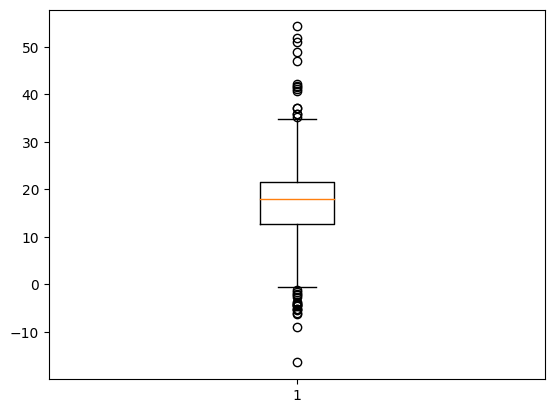

In [ ]:
plt.boxplot(pred_datasets['diff_traffic'])

In [ ]:
final = pd.read_excel("/content/drive/MyDrive/Dive in Data/최종 데이터셋.xlsx")

In [ ]:
pred_datasets[:20]

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr,pred,true_traffic,diff_traffic
0,가마산로,신길가마산로,성락주유소앞,상행,750.0,2.0,보조간선도로,18.30,18.02,18.18,18.38,18.60,36.5530,54.90,18.3470
1,가마산로,성락주유소앞,성락빌딩앞,상행,272.0,2.0,보조간선도로,22.20,22.03,22.03,22.42,22.33,44.4566,66.60,22.1434
2,가마산로,성락빌딩앞,대림3동사거리,상행,416.0,2.0,보조간선도로,24.80,24.91,24.55,24.83,24.92,52.2618,74.40,22.1382
3,가마산로,대림3동사거리,거리공원오거리,상행,444.0,2.0,보조간선도로,19.32,19.50,19.12,19.36,19.31,38.6016,57.96,19.3584
4,가마산로,대림3동사거리,성락빌딩앞,하행,418.0,1.0,보조간선도로,18.91,18.86,18.50,19.24,19.03,19.9413,37.82,17.8787
5,가마산로,성락빌딩앞,성락주유소앞,하행,268.0,1.0,보조간선도로,19.75,19.91,19.38,20.09,19.61,21.0806,39.50,18.4194
6,가마산로,성락주유소앞,신길가마산로,하행,742.0,2.0,보조간선도로,20.96,20.83,20.82,21.13,21.06,41.9560,62.88,20.9240
7,가마산로,신길가마산로,해군회관앞,하행,999.0,2.0,보조간선도로,23.97,24.20,23.73,23.97,23.98,50.4379,71.91,21.4721
8,경인로,도림교,문래동남성아파트,상행,270.0,3.0,주간선도로,22.61,23.60,22.29,22.31,22.24,78.8830,90.44,11.5570
9,경인로,문래동남성아파트,문래동사거리,상행,293.0,3.0,주간선도로,13.31,14.07,13.09,12.97,13.10,42.7303,53.24,10.5097


In [ ]:
duplicate_counts = pred_datasets['Startroad'].value_counts()

# diff_traffic을 우회 도로 수에 따라 분배
pred_datasets['adjusted_diff_traffic'] = pred_datasets.apply(lambda row: row['diff_traffic'] / duplicate_counts[row['Startroad']], axis=1)

In [ ]:
pred_datasets

,Roadname,Startroad,Endroad,Updown,Distance,Number_of_lanes,Function_type,Mean of years,Jan,Feb,Mar,Apr,pred,true_traffic,diff_traffic,adjusted_diff_traffic
0,가마산로,신길가마산로,성락주유소앞,상행,750.0,2.0,보조간선도로,18.30,18.02,18.18,18.38,18.60,36.5530,54.90,18.3470,4.586750
1,가마산로,성락주유소앞,성락빌딩앞,상행,272.0,2.0,보조간선도로,22.20,22.03,22.03,22.42,22.33,44.4566,66.60,22.1434,5.535850
2,가마산로,성락빌딩앞,대림3동사거리,상행,416.0,2.0,보조간선도로,24.80,24.91,24.55,24.83,24.92,52.2618,74.40,22.1382,5.534550
3,가마산로,대림3동사거리,거리공원오거리,상행,444.0,2.0,보조간선도로,19.32,19.50,19.12,19.36,19.31,38.6016,57.96,19.3584,4.839600
4,가마산로,대림3동사거리,성락빌딩앞,하행,418.0,1.0,보조간선도로,18.91,18.86,18.50,19.24,19.03,19.9413,37.82,17.8787,4.469675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,의사당대로,여의교,대한지적공사앞,하행,330.0,3.0,보조간선도로,23.09,23.32,23.24,22.96,22.84,76.0384,92.36,16.3216,3.264320
365,의사당대로,대한지적공사앞,여의도역,하행,324.0,3.0,보조간선도로,18.00,18.30,17.85,17.85,17.98,56.7729,72.00,15.2271,7.613550
366,의사당대로,여의도역,여의도공원앞,하행,364.0,5.0,보조간선도로,26.96,26.80,26.94,27.21,26.89,150.8834,161.76,10.8766,2.719150
367,의사당대로,여의도공원교차로,잠사회관앞,하행,148.0,5.0,보조간선도로,27.56,27.55,27.30,27.77,27.60,154.6915,165.36,10.6685,10.668500


In [ ]:
pred_datasets.to_csv("./traffic_utf-8.csv", encoding='utf-8', index=False)